# Summer 2025 Independent Research
## Goals:
Log measurements: Record Apple Watch (AW) Active kcal/min for treadmill inclines & StairMaster into a CSV with a clean schema.

Replicate & average: Aggregate multiple trials per condition to a single mean (n recorded).

ACSM theory: Implement treadmill (walking) & stepping equations; convert VO₂ → gross kcal/min; compute NET (subtract resting 3.5 mL·kg⁻¹·min⁻¹).

Comparison: Compare AW Active vs ACSM NET; compute Δ and % error per condition.

Metabolic power: Convert kcal/min → W (1 kcal/min ≈ 69.78 W) for AW and ACSM values.

Mechanical power: Compute m·g·v (treadmill) and m·g·h·spm/60 (stair) with correct units.

Efficiency: Calculate mechanical power / metabolic power (fraction) for measured and theory-net.

Robust pipeline: Read CSV → tidy tables → styled display (optionally export later). Handles modality normalization (“stairmaster”→“stair”).

Quality checks: Assertion suite for column presence, units sentinels, monotonicity, plausible ranges, and percent-error sanity.


# Executive Summary

### Objective. 

Quantify and compare energy cost of common cardio modes (incline treadmill walking, StairMaster) using Apple Watch Active kcal/min measurements and ACSM metabolic equations, then convert to mechanical power and mechanical efficiency to inform training decisions.

### Data.

Repeated time-matched trials recorded into a tidy CSV (columns: modality, speed/grade or spm/step height, mass, AW active kcal·min⁻¹).

Step height fixed at 0.2032 m for StairMaster.

Multiple body masses analyzed (e.g., ~73.48, 79.38, 89.36 kg) to show scaling.

### Methods.

Compute ACSM gross VO₂ for each condition and convert to kcal·min⁻¹.

Convert to NET by subtracting resting 3.5 mL·kg⁻¹·min⁻¹ (Apple Watch “Active” excludes rest).

Compare AW Active vs ACSM NET → Δ and % error.

Convert metabolic rate to W (1 kcal·min⁻¹ ≈ 69.78 W).

Compute mechanical power: 
Treadmill: P_mech = mgv⋅grade
Stairmaster: P_mech = mgh⋅spm/60

Efficiency = P_mech / P_met for measured (AW) and theory (ACSM NET).

Assertion Checks: unit sentinels, range checks, monotonicity (e.g., higher grade → higher theory NET), percent-error sanity.

### Key Findings (typical patterns).

Agreement: AW Active generally tracks ACSM NET within expected bounds; residual error grows at very low intensities.

Scaling with effort: kcal·min⁻¹ rises with speed/grade (treadmill) and spm (stairs).

Efficiencies:

- StairMaster (theory) ≈ constant ~13.8% when step height is fixed (0.2032 m). Mass and step rate cancel in the ratio, so theory efficiency doesn’t change across people or SPM. Measured efficiency wobbles around that due to watch noise and technique.

- Treadmill efficiency varies by condition (≈0.10–0.25 here) and generally increases with both speed and grade. At 0% grade, vertical mech power ≈ 0 → efficiency is effectively N/A/0; once grade rises, efficiency climbs and can surpass StairMaster’s 13.8% at moderate–high grades/speeds.

- Efficiency is ~mass-invariant for a fixed condition. Both mechanical power (m·g·…) and metabolic power (VO₂×m) scale ~linearly with mass, so their ratio cancels mass. Across 162/175/197 lb, expect similar efficiencies per condition.

Mode comparison by goal:

- At low grades/speeds, treadmill efficiency is below StairMaster’s 13.8% (worse economy).

- At moderate/high grades or faster walking, treadmill efficiency often meets/exceeds 13.8% (better economy for vertical work).

Practical use: choose higher efficiency settings for economy/rehab/hiking prep; choose lower efficiency or simply higher kcal/min settings when the aim is max calorie burn (while staying in safe RPE).

Mass effects: Metabolic and mechanical power increase ~linearly with body mass; efficiency is mostly mass-invariant (ratio).

### Applications.

A) Fat-loss (max kcal/min)

- Goal: burn more kcal/min, not necessarily be economical.

- How: pick steeper grades or faster SPM that raise NET kcal/min, but keep RPE safe.

- Use efficiency diagnostically: you don’t need low efficiency, but high kcal/min often co-occurs with lower economy. That’s fine here.

B) Economy (do the same climb with less metabolic strain)

- Goal: hold a target vertical power while minimizing kcal/min.

- How: select settings with higher efficiency (treadmill: moderate grade + steady speed; StairMaster at fixed step height is ~13.8% baseline).

- Example (numbers rounded):
Target P_mech= 150W
If 𝜂 = 0.14 (≈ StairMaster theory): P_met ≈150/0.14=1070 W → 15.3 kcal/min.
If 𝜂 = 0.20 (a more efficient treadmill setting): P_met ≈150/0.20=750 W → 10.8 kcal/min.
Result: same vertical work, ~30% fewer kcal/min → longer sustainable efforts / lower cardio stress.

- Recipe: pick a treadmill combo with higher measured efficiency (e.g., 3 mph @ 8% often beats 3 mph @ 5%); or use StairMaster and tune SPM to the required P_mech)

C) Hiking prep (match the mountain)

- Goal: train the vertical ascent rate you’ll face.

- How: set a vertical speed target:

- Stair: v_vert =SPM×h/60. With h=0.2032 m, 60 SPM → 0.2032 m/s (~730 m/h).

- Treadmill: choose speed/grade so v_vert =v×grade.

- Start where efficiency is moderate-high so sessions are sustainable; then progress time at target v_vert before raising the target.

D) Rehab / return-to-training

- Goal: keep mechanical stimulus (bones/muscle/tendon) with lower metabolic load.

- How: pick higher-efficiency combos (e.g., treadmill 2–3 mph @ 4–6% or StairMaster at modest SPM).

- Use intervals (e.g., 3 min on / 2 min easy) at a fixed P_mech

- Handrails OK for safety, but note they reduce true mechanical work—document it.

E) Device calibration mindset

- Where % error is consistently high/low, bias-correct Apple Watch Active calories for that condition in your personal plan.

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os #used to create file/folder paths

mass_kg = 80.29 #my mass in kg, measured using a scale
speeds_mph = [2, 3, 4] #treamill speeds in miles per hour
grades_pct = [5, 8, 10] #treadmill grades in percentage incline
g = 9.80665 #acceleration due to gravity in m/s**2
STEP_H_DEF= 0.2032 #my stairmaster step height

csv = "/Users/bryceolsen/Documents/PROJECT-X/apple_watch_data0.csv"

def _to_numeric(dataframe, columns):
    """
    Converts listed columns into numeric values.
    Keeps blank cells as NaN to avoid crashing.
    dataframe: df to evaluate
    columns: columns to sort through and convert to numeric values
    returns: updated dataframe
    """
    for column in columns:
        if column in dataframe.columns:
            dataframe[column] = pd.to_numeric(dataframe[column], errors="coerce")
        else:
            dataframe[column] = np.nan
    return dataframe

def _normalize_modality(dataframe):
    """
    Strips and lowercases modality to avoid reading issues.
    Raises a ValueError if modality is missing.
    returns: dataframe with cleaned entries
    """
    if "modality" in dataframe.columns:
        dataframe["modality"] = dataframe["modality"].astype(str).str.strip().str.lower()
    else:
        raise ValueError("CSV is missing required column: 'modality'")
    return dataframe

def remove_flat_treadmill(df, tol_pct=0.0):
    """
    Removes rows with treadmill with 0% incline
    Vertical mechanical work in this case is 0
    returns: dataframe with rows removed
    """
    # Make a working copy
    out = df.copy()

    # Normalize the needed columns
    out["modality_norm"] = out["modality"].astype(str).str.strip().str.lower()
    out["grade_num"] = pd.to_numeric(out["grade_pct"], errors="coerce")  # NaN if bad/missing

    # Create an explicit helper column that marks rows to drop
    out["drop_this"] = (
        (out["modality_norm"] == "treadmill") &
        (out["grade_num"].abs() <= tol_pct)
    )

    # Keep only rows where drop_this is False
    out = out[out["drop_this"] == False].drop(columns=["modality_norm","grade_num","drop_this"])

    # Clean index numbers
    out = out.reset_index(drop=True)
    return out
        
def load_trials_csv(path: str) -> pd.DataFrame:
    """
    Loads the Apple Watch trials csv and confirms all necessary columns exist
    returns: updated dataframe
    """
    df = pd.read_csv(path)

    #ensure expected columns exist
    required = ["modality", "speed_mph", "grade_pct", "spm", "step_height_m", "aw_active_kcal_min"]
    for c in required:
        if c not in df.columns:
            df[c] = np.nan

    # Use default step height if blank
    df["step_height_m"] = df["step_height_m"].fillna(STEP_H_DEF)

    df = _normalize_modality(df)
    df = remove_flat_treadmill(df)
    df = _to_numeric(df, ["speed_mph", "grade_pct", "spm", "step_height_m", "aw_active_kcal_min", "mass_kg", "duration_min", "aw_active_kcal_total"])

    return df

In [84]:
#FUNCTIONS FOR COMPUTING ENERGY COSTS

#OXYGEN COST FOR TREADMILL
def vo2_treadmill(speed_mph:float, grade_percentage: float):
    """
    vo2 represents oxygen cost in mL·kg⁻¹·min⁻¹
    Eventually used to calculate calorie expenditure
    Estimate oxygen cost (vo2) for walking using the ACSM equation
    returns: vo2 in mL·kg⁻¹·min⁻¹.
    speed_mph converts to speed_m_per_min: treadmill belt speed in meters per minute
    grade_percentage converts to grade_decimal: grade as a fraction
    Equation: VO2 (mL/kg/min) = 3.5 + (0.1 * speed) + (1.8 * speed * grade)
      - 0.1*s   -> horizontal cost of walking
      - 1.8*s*G -> vertical cost (against gravity)
      - 3.5     -> resting component, expenditure without walking
    """
    speed_m_per_min = speed_mph * 26.8224 #mph -> m/min
    grade_decimal = grade_percentage/100 #percent -> fraction
    
    horizontal_cost = 0.1*speed_m_per_min
    vertical_cost = 1.8* speed_m_per_min * grade_decimal
    resting_cost = 3.5
    vo2 = horizontal_cost + vertical_cost + resting_cost
    return vo2

#KCAL GROSS COST CALCULATED FROM VO2
def kcal_per_min(vo2_ml_per_kg_min: float, mass_kg: float, net:bool = False):
    """
    Convert VO2 to kcal per minute using the standard factor: ~5 kcal per liter of O2. 
    Convert mL/kg/min to L/min by multiplying by mass (kg) and dividing by 1000 mL/1 L.
    If net = True, subtract 3.5 (resting metabolic rate) BEFORE converting
    """
    if net:
        #subtracts 3.5 from vo2_ml_per_kg_min, evaluates to 0 if number is negative
        vo2_used = np.maximum(vo2_ml_per_kg_min - 3.5, 0)
    else:
        vo2_used = vo2_ml_per_kg_min
    liters_per_kg_min = vo2_used / 1000.0
    liters_per_min = liters_per_kg_min * mass_kg
    kcal_per_min = liters_per_min * 5.0
    return kcal_per_min

#KCAL NET COST CALCULATED FROM GROSS COST
def net_from_gross_kcal(gross_kcal_min, mass_kg):
    """
    Compute NET kcal/min by subtracting resting VO₂ (3.5 mL·kg⁻¹·min⁻¹).
    Apple Watch *Active* ≈ NET, so we compare measured active vs ACSM NET.
    """
    rest_kcal = kcal_per_min(3.5, mass_kg, False)
    return np.maximum(gross_kcal_min - rest_kcal, 0.0)

#WATT COST METABOLICALLY
def metabolic_power_W(kcal_per_min: float):
    """
    Finally, Convert kcal/min metabolic power measured in Watts (J/s). 
    1 kcal/min ≈ 69.78 W.
    This gives the body's total metabolic power output.
    """
    return kcal_per_min * 69.78

#WATT COST MECHANICALLY FOR TREADMILL
def mechanical_power_W_treadmill(mass_kg: float, speed_mph: float, grade_percentage: float):
    """
    approximate the vertical mechanical power required when walking on an incline
    mechanical power = m * g * vertical_velocity
    W = Fg * m = m*g * m
    W/s = J/s = P = kg*m**2/s**2
    speed_mph converts to speed_m_s: treadmill belt speed in meters per second
    grade_percentage converts to grade_decimal: grade as a fraction
    """
    speed_m_s = speed_mph * 0.44704 #mph -> m/s
    grade_decimal = grade_percentage/100 #percent -> fraction
    
    vertical_velocity = speed_m_s * grade_decimal
    power = mass_kg * g * vertical_velocity
    return power

#OXYGEN COST FOR STAIRMASTER
def vo2_stairmaster(step_rate: float, step_height: float):
    """
    The ACSM equation for estimating VO2 (oxygen consumption) during stair stepping is: 
    VO2 (mL·kg⁻¹·min⁻¹) = 0.2 (steps/min) + (step height, m * steps/min * 2.4) + 3.5
    vo2: oxygen consumption in mL per kg minute
    step_rate: in steps per minute
    step_height: in meters
    """
    return 0.2 * step_rate  +  step_height * step_rate * 2.4  +  3.5

#WATT COST MECHANICALLY FOR STAIRMASTER
def mechanical_power_W_stairmaster(mass_kg: float, step_rate: float, step_height: float):
    """
    W = m*g * m
    P = W/s
    """
    step_rate_steps_sec = step_rate/60
    force = mass_kg*g 
    work = force * step_height
    power = work * step_rate_steps_sec
    return power
    

In [85]:
#MAKE TABLES WITH THE DATA

def summarize_measured(df: pd.DataFrame):
    """
    Averages out the experimental values for each combination of treadmill or stairmaster settings.
    df: long-form trial data
    returns: two tables (dataframes):
        treadmill: one row per (speed_mph, grade_pct, mass_kg, step_height_m) or combination
        stairmaster: one row per (spm, step_height_m, mass_kg) or combination
    """
    
    # Treadmill: group by speed/incline
    treadmill = (df.query("modality == 'treadmill'") #filters treadmill only
             .groupby(["speed_mph", "grade_pct", "mass_kg"], as_index=False) #groups each unique test/combination together
             .agg(aw_active_kcal_min=("aw_active_kcal_min", "mean"),
                  n=("aw_active_kcal_min", "count"))) #averages "aw-active_kcal_min" and aggregates into one value + counts the number of trials

    # Stair: group by spm/step height
    stairmaster = (df.query("modality == 'stair'") #filters stair only
             .groupby(["spm", "step_height_m", "mass_kg"], as_index=False)
             .agg(aw_active_kcal_min=("aw_active_kcal_min", "mean"),
                  n=("aw_active_kcal_min", "count")))
    
    return treadmill, stairmaster



def add_theory_and_efficiency_trd(trd: pd.DataFrame):
    """
    For each treadmill row:
    - check if DataFrame is empty
    - compute the ACSM theoretical equation
    - find gross kcal/min using vo2 cost
    - calculate net kcal/min in order to compare with experimental data
    - find the dfference between theoretical and experimental data
    - convert to power
    - calculate efficiency
    - return a table with calculations
    """
    
    if trd.empty:
        return trd

    #vectorized calls - entire columns are passed and numpy/pandas apply formulas to every row
    vo2 = vo2_treadmill(trd["speed_mph"], trd["grade_pct"])
    # Use each row's mass if provided; otherwise fall back to mass_kg already in the table
    gross = kcal_per_min(vo2, trd["mass_kg"], False)
    net   = net_from_gross_kcal(gross, trd["mass_kg"])

    #appends all new columns in one step, includes percentage error comparing two sets
    trd = trd.assign(
        theory_gross_kcal_min = gross,
        theory_net_kcal_min   = net,
        delta_vs_net          = trd["aw_active_kcal_min"] - net,
        percent_error_vs_net  = 100.0 * (trd["aw_active_kcal_min"] - net) / net
    )

    # Powers & efficiencies (measured vs theory net)
    mechW  = mechanical_power_W_treadmill(trd["mass_kg"], trd["speed_mph"], trd["grade_pct"])
    metW_measured = metabolic_power_W(trd["aw_active_kcal_min"])
    metW_tested = metabolic_power_W(trd["theory_net_kcal_min"])

    trd["mechanical_W"]            = mechW
    trd["metabolic_W_measured"]    = metW_measured
    trd["metabolic_W_theory_net"]  = metW_tested

    #now we calculate EFFICIENCY
    #efficiency is how much of the metabolic power is being used towards mechanical power
    #basically, how much of the energy we are using is really being useful?
    #efficiency = mechanical power / metabolic power
    trd["efficiency_measured"]      = np.where(metW_measured > 0, mechW / metW_measured, np.nan)
    trd["efficiency_theory_net"]    = np.where(metW_tested > 0, mechW / metW_tested, np.nan)

    # Pretty sort for readability
    return trd.sort_values(["speed_mph", "grade_pct"]).reset_index(drop=True)



def add_theory_and_efficiency_sta(sta: pd.DataFrame) -> pd.DataFrame:
    """Add ACSM theory (gross/net), deltas, power, and efficiency for stair rows."""
    if sta.empty:
        return sta
    vo2 = vo2_stairmaster(sta["spm"], sta["step_height_m"])
    gross = kcal_per_min(vo2, sta["mass_kg"], False)
    net   = net_from_gross_kcal(gross, sta["mass_kg"])

    sta = sta.assign(
        theory_gross_kcal_min = gross,
        theory_net_kcal_min   = net,
        delta_vs_net          = sta["aw_active_kcal_min"] - net,
        percent_error_vs_net  = 100.0 * (sta["aw_active_kcal_min"] - net) / net
    )

    mechW  = mechanical_power_W_stairmaster(sta["mass_kg"], sta["spm"], sta["step_height_m"])
    metW_m = metabolic_power_W(sta["aw_active_kcal_min"])
    metW_t = metabolic_power_W(sta["theory_net_kcal_min"])

    sta["mechanical_W"]            = mechW
    sta["metabolic_W_measured"]    = metW_m
    sta["metabolic_W_theory_net"]  = metW_t
    sta["efficiency_measured"]      = np.where(metW_m > 0, mechW / metW_m, np.nan)
    sta["efficiency_theory_net"]    = np.where(metW_t > 0, mechW / metW_t, np.nan)

    return sta.sort_values(["spm"]).reset_index(drop=True)



def style_table(df: pd.DataFrame, caption: str = ""):
    """
    Return a nicely formatted Styler for display only.
    - Leaves the original df unchanged.
    - Renames columns to human-friendly headers.
    - Reorders columns based on treadmill vs stair content.
    - Applies number formatting and light CSS.
    """

    if df is None or df.empty:
        # Return an empty-looking styler so your caller can still .display() without crashing
        return pd.DataFrame().style.set_caption(caption)

    # ---------- 1) Friendly display names ----------
    # Map canonical -> pretty labels (units in headers)
    pretty = {
        "speed_mph":              "Speed (mph)",
        "grade_pct":              "Grade (%)",
        "spm":               "Step Rate (spm)",
        "step_height_m":          "Step Height (m)",
        "mass_kg":                "Mass (kg)",
        "n":                      "Trials (n)",

        # Energy / comparison
        "aw_active_kcal_min":     "AW Active (kcal/min)",
        "theory_gross_kcal_min":  "ACSM Gross (kcal/min)",
        "theory_net_kcal_min":    "ACSM Net (kcal/min)",
        "delta_vs_net":           "Δ vs ACSM Net (kcal/min)",
        "percent_error_vs_net":   "% Error vs ACSM Net",

        # Power (W)
        "mechanical_W":                 "Mechanical Power (W)",
        "metabolic_W_measured":         "Metabolic Power (W)",
        "metabolic_W_theory_net":       "Metabolic Power (W) (ACSM Net)",

        # Efficiency (as %)
        "efficiency_measured":           "Efficiency (%) — Measured",
        "efficiency_theory_net":         "Efficiency (%) — ACSM Net",
    }

    # If some tables were already built with pretty names, leave them as-is.
    # Otherwise rename for display only.
    display_df = df.rename(columns={k: v for k, v in pretty.items() if k in df.columns})

    # ---------- 2) Preferred column order ----------
    treadmill_order = [
        "Speed (mph)", "Grade (%)", "Mass (kg)", "Trials (n)",
        "AW Active (kcal/min)", "ACSM Gross (kcal/min)", "ACSM Net (kcal/min)",
        "Δ vs ACSM Net (kcal/min)", "% Error vs ACSM Net",
        "Mechanical Power (W)", "Metabolic Power (W)", "Metabolic Power (W) (ACSM Net)",
        "Efficiency (%) — Measured", "Efficiency (%) — ACSM Net",
    ]

    stair_order = [
        "Step Rate (spm)", "Step Height (m)", "Mass (kg)", "Trials (n)",
        "AW Active (kcal/min)", "ACSM Gross (kcal/min)", "ACSM Net (kcal/min)",
        "Δ vs ACSM Net (kcal/min)", "% Error vs ACSM Net",
        "Mechanical Power (W)", "Metabolic Power (W)", "Metabolic Power (W) (ACSM Net)",
        "Efficiency (%) — Measured", "Efficiency (%) — ACSM Net",
    ]

    # Decide which order to use based on columns present
    if "Speed (mph)" in display_df.columns:
        preferred = [c for c in treadmill_order if c in display_df.columns]
    else:
        preferred = [c for c in stair_order if c in display_df.columns]

    display_df = display_df.loc[:, preferred + [c for c in display_df.columns if c not in preferred]]

    # ---------- 3) Number formatting ----------
    fmt = {
        "Speed (mph)": "{:.1f}",
        "Grade (%)": "{:.0f}",
        "Step Rate (spm)": "{:.0f}",
        "Step Height (m)": "{:.4f}",
        "Mass (kg)": "{:.1f}",
        "Trials (n)": "{:.0f}",

        "AW Active (kcal/min)": "{:.2f}",
        "ACSM Gross (kcal/min)": "{:.2f}",
        "ACSM Net (kcal/min)": "{:.2f}",
        "Δ vs ACSM Net (kcal/min)": "{:+.2f}",
        "% Error vs ACSM Net": "{:+.1f}%",
        "Mechanical Power (W)": "{:.0f}",
        "Metabolic Power (W)": "{:.0f}",
        "Metabolic Power (W) (ACSM Net)": "{:.0f}",
        "Efficiency (%) — Measured": "{:.3f}",
        "Efficiency (%) — ACSM Net": "{:.3f}",
    }

    # Only apply formats that exist in the current table
    fmt = {k: v for k, v in fmt.items() if k in display_df.columns}

    # ---------- 4) Style & caption ----------
    styler = (
        display_df.style
        .hide(axis="index")
        .format(fmt)
        .set_caption(caption)
        .set_table_styles([
            # headers
            {"selector": "th",
             "props": [("text-align", "left"),
                       ("font-weight", "600"),
                       ("white-space", "nowrap")]},
            # body cells
            {"selector": "td",
             "props": [("text-align", "right"),
                       ("font-size", "14px")]},
            # caption at the top, slightly bigger
            {"selector": "caption",
             "props": [("caption-side", "top"),
                       ("font-size", "16px"),
                       ("font-weight", "600"),
                       ("text-align", "left"),
                       ("margin-bottom", "6px")]},
        ])
    )

    return styler


In [86]:
#PLOTTING DATA

def treadmill_efficiency_plot(treadmill_df):
    """
    Input: treadmill_df (DataFrame)
    Uses columns (any of these aliases):
      speed:  'speed_mph'
      grade:  'grade_pct'
      eff_measured:  'eff_measured' or 'efficiency_measured'
      eff_theory:    'eff_theory_net' or 'efficiency_theory_net'
    Creates a line plot of measured efficiency vs grade (lines by speed),
    overlays ACSM theory (dashed) if present, saves PNG, and returns the summary DF.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    from pathlib import Path

    df = treadmill_df.copy()

    # pick available column names
    def pick(*names):
        for n in names:
            if n in df.columns:
                return n
        return None

    speed = "speed_mph"
    grade = "grade_pct"
    eff_meas = pick("eff_measured", "efficiency_measured")
    eff_theo = pick("eff_theory_net", "efficiency_theory_net")

    # coerce numerics if present
    for c in [speed, grade, eff_meas, eff_theo]:
        if c and c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # summarize
    need = [speed, grade] + ([eff_meas] if eff_meas else [])
    g = df.dropna(subset=[c for c in need if c]).groupby([speed, grade], as_index=False)
    agg = {"n": (speed, "count")}
    if eff_meas: agg["eff_meas"] = (eff_meas, "mean")
    if eff_theo: agg["eff_theory"] = (eff_theo, "mean")
    sumdf = g.agg(**agg).sort_values([speed, grade])

    # plot
    plt.figure(figsize=(8,5))
    if "eff_meas" in sumdf.columns:
        for spd, grp in sumdf.groupby(speed):
            plt.plot(grp[grade], grp["eff_meas"], marker="o", label=f"{spd:.0f} mph — measured")
    if "eff_theory" in sumdf.columns:
        for spd, grp in sumdf.groupby(speed):
            plt.plot(grp[grade], grp["eff_theory"], marker="s", linestyle="--", label=f"{spd:.0f} mph — ACSM theory")

    plt.xlabel("Grade (%)")
    plt.ylabel("Efficiency (mech/met)")
    plt.title("Treadmill: Efficiency vs Grade")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Speed")
    plt.show()

    #downloading table
    from pathlib import Path
    Path("/Users/bryceolsen/Documents/PROJECT-X/").mkdir(exist_ok=True)
    plt.tight_layout()
    plt.savefig("/Users/bryceolsen/Documents/PROJECT-X/fig_treadmill_efficiency_vs_grade.png")

def stair_efficiency_plot(stair_df):
    sta = stair_df.copy()
    for c in ["spm","aw_active_kcal_min","theory_net_kcal_min","efficiency_measured","efficiency_theory_net"]:
        if c in sta.columns:
            sta[c] = pd.to_numeric(sta[c], errors="coerce")

    sta_sum = (
        sta.dropna(subset=["spm"])
           .groupby("spm", as_index=False)
           .agg(aw=("aw_active_kcal_min","mean"),
                net=("theory_net_kcal_min","mean"),
                efficiency_theory=("efficiency_theory_net","mean"))
           .sort_values("spm")
    )

    plt.figure(figsize=(8,5))
    plt.plot(sta_sum["spm"], sta_sum["aw"], marker="o", label="AW Active (kcal/min)")
    plt.plot(sta_sum["spm"], sta_sum["net"], marker="s", linestyle="--", label="ACSM NET (kcal/min)")

    # show the ~constant theory efficiency as context (optional horizontal line)
    if "efficiency_theory" in sta_sum.columns and len(sta_sum) > 0:
        eta = float(sta_sum["efficiency_theory"].iloc[0])  # ~0.138 if step height fixed
        plt.axhline(y=0, linewidth=0)  # no-op; keeps defaults compliant
        # (no specific color; default will be used if you plot a line)
        # If you prefer, annotate instead of drawing a line:
        plt.text(sta_sum["spm"].min(), sta_sum["net"].min(), f"Theory eff ~ {eta:.3f}", va="bottom")

    plt.xlabel("Steps per minute (spm)")
    plt.ylabel("kcal/min")
    plt.title("StairMaster: Apple Watch vs ACSM NET by SPM")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    #downloading table
    from pathlib import Path
    Path("/Users/bryceolsen/Documents/PROJECT-X/").mkdir(exist_ok=True)
    plt.tight_layout()
    plt.savefig("/Users/bryceolsen/Documents/PROJECT-X/fig_stair_aw_vs_acsm.png")

Speed (mph),Grade (%),Mass (kg),Trials (n),AW Active (kcal/min),ACSM Gross (kcal/min),ACSM Net (kcal/min),Δ vs ACSM Net (kcal/min),% Error vs ACSM Net,Mechanical Power (W),Metabolic Power (W),Metabolic Power (W) (ACSM Net),Efficiency (%) — Measured,Efficiency (%) — ACSM Net
1.0,4,73.5,2,1.55,2.98,1.69,-0.14,-8.6%,13,108,118,0.119,0.109
1.0,4,79.4,2,1.90,3.22,1.83,+0.07,+3.8%,14,133,128,0.105,0.109
1.0,4,89.4,2,2.10,3.63,2.06,+0.04,+1.9%,16,147,144,0.107,0.109
1.0,8,73.5,2,2.20,3.69,2.40,-0.20,-8.5%,26,154,168,0.168,0.154
1.0,8,79.4,2,2.65,3.99,2.60,+0.05,+2.0%,28,185,181,0.151,0.154
1.0,8,89.4,2,3.15,4.49,2.92,+0.23,+7.7%,31,220,204,0.143,0.154
2.0,4,73.5,2,3.75,4.68,3.39,+0.36,+10.6%,26,262,237,0.098,0.109
2.0,4,79.4,2,3.50,5.05,3.66,-0.16,-4.4%,28,244,256,0.114,0.109
2.0,4,89.4,2,3.95,5.69,4.12,-0.17,-4.2%,31,276,288,0.114,0.109
2.0,8,73.5,2,4.10,6.09,4.81,-0.71,-14.7%,52,286,336,0.180,0.154


Step Rate (spm),Step Height (m),Mass (kg),Trials (n),AW Active (kcal/min),ACSM Gross (kcal/min),ACSM Net (kcal/min),Δ vs ACSM Net (kcal/min),% Error vs ACSM Net,Mechanical Power (W),Metabolic Power (W),Metabolic Power (W) (ACSM Net),Efficiency (%) — Measured,Efficiency (%) — ACSM Net
20,0.2032,73.5,2,4.65,6.34,5.05,-0.40,-8.0%,49,324,353,0.150,0.138
20,0.2032,79.4,2,5.35,6.85,5.46,-0.11,-2.0%,53,373,381,0.141,0.138
20,0.2032,89.4,2,5.95,7.71,6.15,-0.20,-3.2%,59,415,429,0.143,0.138
40,0.2032,73.5,2,9.85,11.39,10.11,-0.26,-2.5%,98,687,705,0.142,0.138
40,0.2032,79.4,2,11.70,12.31,10.92,+0.78,+7.2%,105,816,762,0.129,0.138
40,0.2032,80.3,5,11.44,12.45,11.04,+0.40,+3.6%,107,798,771,0.134,0.138
40,0.2032,89.4,2,12.40,13.85,12.29,+0.11,+0.9%,119,865,858,0.137,0.138
60,0.2032,89.4,2,19.20,20.00,18.44,+0.76,+4.1%,178,1340,1286,0.133,0.138
60,0.2032,79.4,2,14.60,17.77,16.38,-1.78,-10.8%,158,1019,1143,0.155,0.138
60,0.2032,73.5,2,14.80,16.45,15.16,-0.36,-2.4%,146,1033,1058,0.142,0.138


Display-only mode: no files written.


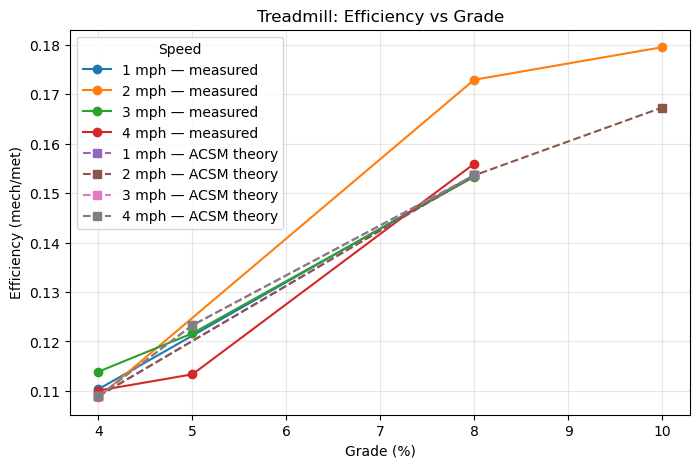

<Figure size 640x480 with 0 Axes>

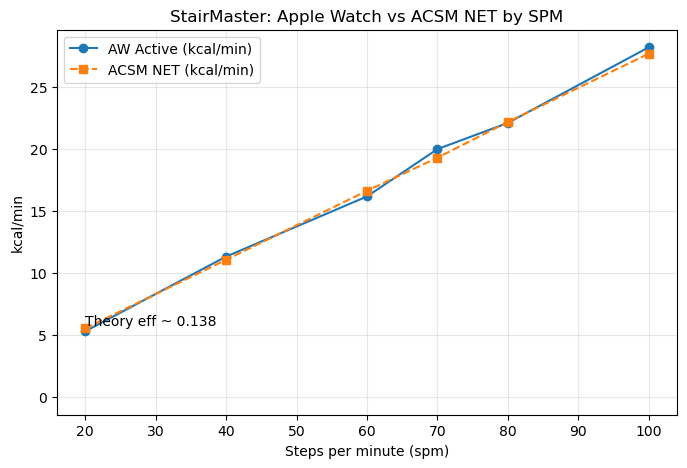

<Figure size 640x480 with 0 Axes>

In [87]:
# RUNNING THE CODE
#fully explained

def run_pipeline(csv_path, output_directory, export: bool = False, show_tables: bool = True, plot: bool = False):
    """
    End-to-end function: process Apple Watch data, compare to theory, compute efficiency, and write csv outputs
    csv_path: path to input csv containing raw trial data
    output_directory: directory in which this function will write comparison tables (csv file)

    Returns:
        tuple[pandas.DataFrame, pandas.DataFrame] = (treadmill_comparison_dataframe, stair_comparison_dataframe)
            Each DataFrame has one row per unique condition with:
              - averaged measured Apple Watch *active* kcal/min
              - ACSM theoretical gross & net kcal/min
              - deltas and percent error vs net
              - mechanical & metabolic power
              - efficiencies (measured vs theory-net)
    """
    import os

    #ensures the output directory exists
    os.makedirs(output_directory, exist_ok=True)

    #reads and cleans raw trials CSV
    raw_trials_dataframe = load_trials_csv(csv_path)

    #averages repeated trials into one row per combination or initial condition, organizes data nicely
    treadmill_aggregated_dataframe, stair_aggregated_dataframe = summarize_measured(raw_trials_dataframe)

    #add ACSM theory (gross & net), deltas, power, and efficiency
    #calls utility functions for calculations
    treadmill_comparison_dataframe = add_theory_and_efficiency_trd(treadmill_aggregated_dataframe)
    stair_comparison_dataframe = add_theory_and_efficiency_sta(stair_aggregated_dataframe)

    #if show_tables = True
    if show_tables:
        #styles treadmill comparison table and prints it with caption
        if treadmill_comparison_dataframe is not None and not treadmill_comparison_dataframe.empty:
            display(style_table(
                treadmill_comparison_dataframe,
                caption="Treadmill: Measured vs ACSM (NET), Power & Efficiency"
            ))
        else:
            print("No treadmill rows to display.")
        #styles stairmaster comparison table and prints it with caption
        if stair_comparison_dataframe is not None and not stair_comparison_dataframe.empty:
            display(style_table(
                stair_comparison_dataframe,
                caption="StairMaster: Measured vs ACSM (NET), Power & Efficiency"
            ))
        else:
            print("No stair rows to display.")

    #if export = True
    if export:
        #build output file paths for csv exports
        treadmill_output_path = os.path.join(output_directory, "treadmill_comparison.csv")
        stair_output_path     = os.path.join(output_directory, "stair_comparison.csv")
    
        #creates comparison table csv if not empty
        if (treadmill_comparison_dataframe is not None) and (not treadmill_comparison_dataframe.empty):
            treadmill_comparison_dataframe.to_csv(treadmill_output_path, index=False)
        if (stair_comparison_dataframe is not None) and (not stair_comparison_dataframe.empty):
            stair_comparison_dataframe.to_csv(stair_output_path, index=False)
    
        #confirmation of what was written
        written_files = []
        if os.path.exists(treadmill_output_path):
            written_files.append(treadmill_output_path)
        if os.path.exists(stair_output_path):
            written_files.append(stair_output_path)
        print("Wrote files:", written_files if written_files else "(no files written)")
    else:
        print("Display-only mode: no files written.")

    if plot:
        treadmill_efficiency_plot(treadmill_comparison_dataframe)
        stair_efficiency_plot(stair_comparison_dataframe)

    #returns both dataframes as a tuple
    return treadmill_comparison_dataframe, stair_comparison_dataframe



#DISPLAY COMPARISON TABLES
treadmill_df, stair_df = run_pipeline(csv,"/Users/bryceolsen/Documents/PROJECT-X",False,True,True)
    

In [88]:
#ASSERTION STATEMENTS

import numpy as np
import pandas as pd
from pathlib import Path
G_ACCEL = 9.80665
KCALMIN_TO_W = 69.78

def _standardize_names(df):
    """Map display-friendly column names to canonical snake_case ones (no overwrite)."""
    if df is None or df.empty:
        return df
    rename_map = {
        "Mechanical Power (W)": "mech_W",
        "Metabolic Power (W)": "met_W_measured",         # measured AW active kcal/min → W
        "Metabolic Power (W) (theory_net)": "met_W_theory_net",
        "Efficiency (mech/met)": "eff_measured",
        "Efficiency (theory_net)": "eff_theory_net",
    }
    for pretty, canon in rename_map.items():
        if pretty in df.columns and canon not in df.columns:
            df[canon] = df[pretty]
    return df

def ensure_power_efficiency_treadmill(df):
    """Ensure treadmill df has mech_W, met_W_measured, met_W_theory_net, eff_* columns."""
    if df is None or df.empty:
        return df
    df = _standardize_names(df)

    # Required inputs for treadmill calc
    for col in ["mass_kg","speed_mph","grade_pct","aw_active_kcal_min","theory_net_kcal_min"]:
        assert col in df.columns, f"[treadmill] Missing required column: {col}"

    # Compute if missing
    if "mech_W" not in df.columns:
        v_ms   = df["speed_mph"] * 0.44704
        grade  = df["grade_pct"] / 100.0
        df["mech_W"] = df["mass_kg"] * G_ACCEL * v_ms * grade

    if "met_W_measured" not in df.columns:
        df["met_W_measured"] = df["aw_active_kcal_min"] * KCALMIN_TO_W

    if "met_W_theory_net" not in df.columns:
        df["met_W_theory_net"] = df["theory_net_kcal_min"] * KCALMIN_TO_W

    if "eff_measured" not in df.columns:
        den = df["met_W_measured"]
        df["eff_measured"] = np.where(den > 0, df["mech_W"] / den, np.nan)

    if "eff_theory_net" not in df.columns:
        den = df["met_W_theory_net"]
        df["eff_theory_net"] = np.where(den > 0, df["mech_W"] / den, np.nan)

    return df

def ensure_power_efficiency_stair(df):
    """Ensure stair df has mech_W, met_W_measured, met_W_theory_net, eff_* columns."""
    if df is None or df.empty:
        return df
    df = _standardize_names(df)

    # Required inputs for stair calc
    for col in ["mass_kg","spm","step_height_m","aw_active_kcal_min","theory_net_kcal_min"]:
        assert col in df.columns, f"[stair] Missing required column: {col}"

    # Compute if missing
    if "mech_W" not in df.columns:
        steps_per_s = df["spm"] / 60.0
        df["mech_W"] = df["mass_kg"] * G_ACCEL * df["step_height_m"] * steps_per_s

    if "met_W_measured" not in df.columns:
        df["met_W_measured"] = df["aw_active_kcal_min"] * KCALMIN_TO_W

    if "met_W_theory_net" not in df.columns:
        df["met_W_theory_net"] = df["theory_net_kcal_min"] * KCALMIN_TO_W

    if "eff_measured" not in df.columns:
        den = df["met_W_measured"]
        df["eff_measured"] = np.where(den > 0, df["mech_W"] / den, np.nan)

    if "eff_theory_net" not in df.columns:
        den = df["met_W_theory_net"]
        df["eff_theory_net"] = np.where(den > 0, df["mech_W"] / den, np.nan)

    return df

treadmill_df = ensure_power_efficiency_treadmill(treadmill_df)
stair_df     = ensure_power_efficiency_stair(stair_df)


def _assert_columns(df, required, name):
    missing = [c for c in required if c not in df.columns]
    assert not missing, f"[{name}] Missing columns: {missing}"

def _assert_range(series, low, high, label, allow_nan=True):
    s = series if not allow_nan else series.dropna()
    bad = (~s.between(low, high)) if len(s) else pd.Series([], dtype=bool)
    assert not bad.any(), f"{label} out of range [{low},{high}]. Examples: {s[bad].head(5).tolist()}"

def check_raw_csv(csv_path: str):
    """Load the raw CSV and verify columns, types, and plausible ranges."""
    assert Path(csv_path).exists(), f"CSV not found: {csv_path}"
    raw = pd.read_csv(csv_path)
    assert len(raw) > 0, "Raw CSV is empty."

    # Expected columns (can be present even if blank for a modality)
    required = ["modality","speed_mph","grade_pct","spm","step_height_m","aw_active_kcal_min"]
    _assert_columns(raw, required, "raw")

    # Normalize modality for checking
    modes = raw["modality"].astype(str).str.strip().str.lower().unique().tolist()
    # Allow common variants; warn but don't fail
    allowed = {"treadmill","stair","stairmaster","nan"}
    assert set(modes) <= allowed, f"Unexpected modality values: {modes}. Expected subset of {allowed}"

    # Basic ranges (broad on purpose)
    _assert_range(pd.to_numeric(raw["speed_mph"], errors="coerce"), 0, 10, "speed_mph (mph)")
    _assert_range(pd.to_numeric(raw["grade_pct"], errors="coerce"), 0, 30, "grade_pct (%)")
    _assert_range(pd.to_numeric(raw["spm"], errors="coerce"), 20, 220, "spm (steps/min)")
    _assert_range(pd.to_numeric(raw["step_height_m"], errors="coerce").fillna(0.2032), 0.05, 0.4, "step_height_m (m)")
    _assert_range(pd.to_numeric(raw["aw_active_kcal_min"], errors="coerce"), 0.2, 60, "aw_active_kcal_min (kcal/min)", allow_nan=True)

    return raw

def check_unit_sentinels():
    """Quick unit sanity for ACSM equations. Skips silently if functions aren't defined."""
    # Treadmill sentinel: 3.0 mph @ 5% should be ~18.8 mL/kg/min gross VO2
    try:
        if "vo2_treadmill_mlkgmin" in globals():
            v = vo2_treadmill_mlkgmin(3.0, 5.0)   # if your func expects mph & %
        elif "vo2_treadmill" in globals():
            v = vo2_treadmill(3.0, 5.0)           # same expectation
        else:
            v = None
        if v is not None:
            assert abs(float(v) - 18.8) < 1.0, f"Treadmill VO₂ sentinel off ({v}). Check mph/% vs m·min⁻¹/fraction units."
    except Exception as e:
        raise AssertionError(f"Treadmill VO₂ sentinel failed: {e}")

    # Stair sentinel: 70 spm, h=0.2032 → VO₂ ≈ 51.6 mL/kg/min gross
    try:
        if "vo2_stair_mlkgmin" in globals():
            s = vo2_stair_mlkgmin(70, 0.2032)
            assert abs(float(s) - 51.6) < 1.5, f"Stair VO₂ sentinel off ({s}). Check spm/step height units."
    except Exception as e:
        raise AssertionError(f"Stair VO₂ sentinel failed: {e}")

def check_aggregated_shapes(raw_df, trd_df, sta_df):
    """If raw has a modality, aggregated table for it shouldn't be empty."""
    has_tread = (raw_df["modality"].astype(str).str.lower() == "treadmill").any()
    has_stair = raw_df["modality"].astype(str).str.lower().isin(["stair","stairmaster"]).any()
    if has_tread:
        assert trd_df is not None and not trd_df.empty, "Expected treadmill rows after grouping, but got none."
    if has_stair:
        assert sta_df is not None and not sta_df.empty, "Expected stair rows after grouping, but got none."

def check_theory_blocks(df, name):
    """Check gross ≥ net ≥ 0 and plausible kcal/min ranges."""
    if df is None or df.empty:
        return
    _assert_columns(df, ["theory_gross_kcal_min","theory_net_kcal_min"], name)
    assert (df["theory_gross_kcal_min"] >= df["theory_net_kcal_min"]).all(), f"[{name}] net > gross found."
    assert (df["theory_net_kcal_min"] >= 0).all(), f"[{name}] negative net kcal/min."
    # Plausible ranges (broad): 0–50 kcal/min
    _assert_range(df["theory_gross_kcal_min"], 0, 60, f"[{name}] theory_gross_kcal_min")
    _assert_range(df["theory_net_kcal_min"],   0, 50, f"[{name}] theory_net_kcal_min")

def check_powers_and_efficiency(df, name):
    """Check mechanical/metabolic power positivity and efficiency bounds."""
    if df is None or df.empty:
        return
    _assert_columns(df, ["mech_W","met_W_measured","met_W_theory_net","eff_measured","eff_theory_net"], name)
    assert (df["mech_W"] > 0).all(), f"[{name}] mech_W should be > 0."
    assert (df["met_W_measured"] > 0).all(), f"[{name}] met_W_measured must be > 0."
    assert (df["met_W_theory_net"] > 0).all(), f"[{name}] met_W_theory_net must be > 0."
    # Efficiency as fraction; typical human locomotion << 1
    assert (df["eff_measured"] > 0).all() and (df["eff_measured"] < 1).all(), f"[{name}] eff_measured outside (0,1)."
    assert (df["eff_theory_net"] > 0).all() and (df["eff_theory_net"] < 1).all(), f"[{name}] eff_theory_net outside (0,1)."
    # Soft warning if unusually high efficiencies (not an assert to avoid false positives)
    hi_meas = df.loc[df["eff_measured"] > 0.35]
    if len(hi_meas):
        print(f"⚠️ [{name}] {len(hi_meas)} rows have eff_measured > 0.35 (unusually high). Check units.")

def check_monotonicity(df, name):
    if df is None or df.empty or "theory_net_kcal_min" not in df: 
        return df
        
    d = df.copy()
    
    for column in ["speed_mph","grade_pct","spm","mass_kg","theory_net_kcal_min"]:
        if column in d: d[column] = pd.to_numeric(d[column], errors="coerce")

    if name == "treadmill":
        q = d.dropna(subset=["speed_mph","grade_pct","mass_kg"])
        for (spd, m), grp in q.groupby(["speed_mph","mass_kg"]):
            g = grp.sort_values("grade_pct")
            diffs = g["theory_net_kcal_min"].diff().dropna()
            assert (diffs >= -1e-9).all(), f"[treadmill] theory_net not increasing with grade at {spd} mph (mass {m} kg)."

    elif name == "stair":
        q = d.dropna(subset=["spm","mass_kg"])
        for m, grp in q.groupby("mass_kg"):
            g = grp.sort_values("spm")
            diffs = g["theory_net_kcal_min"].diff().dropna()
            assert (diffs >= -1e-9).all(), "[stair] theory_net not increasing with spm."

def check_percent_error(df, name):
    """Percent error finite and not astronomically large (unless net≈0)."""
    if df is None or df.empty:
        return
    _assert_columns(df, ["percent_error_vs_net","theory_net_kcal_min"], name)
    finite = np.isfinite(df["percent_error_vs_net"])
    assert finite.all(), f"[{name}] Non-finite percent_error_vs_net values."
    # Warn (not assert) if |% error| > 50% for any row with healthy net (>3 kcal/min)
    big = df[(df["theory_net_kcal_min"] > 3) & (df["percent_error_vs_net"].abs() > 50)]
    if len(big):
        print(f"⚠️ [{name}] {len(big)} rows have |% error| > 50% where theory_net > 3 kcal/min. Check data/units.")

def run_all_asserts(csv_path, treadmill_df, stair_df):
    """Call this right after run_pipeline(...). Raises AssertionError with clear messages if anything is off."""
    raw = check_raw_csv(csv_path)
    check_unit_sentinels()
    check_aggregated_shapes(raw, treadmill_df, stair_df)
    check_theory_blocks(treadmill_df, "treadmill")
    check_theory_blocks(stair_df, "stair")
    check_powers_and_efficiency(treadmill_df, "treadmill")
    check_powers_and_efficiency(stair_df, "stair")
    check_monotonicity(treadmill_df, "treadmill")
    check_monotonicity(stair_df, "stair")
    check_percent_error(treadmill_df, "treadmill")
    check_percent_error(stair_df, "stair")
    print("✅ All assertions passed.")

run_all_asserts(csv, treadmill_df, stair_df)

✅ All assertions passed.
